In [18]:
fname="strat_Profiles_Land_sampled_train.nc"
import netCDF4 as nc
import numpy as np
npoints=15
with nc.Dataset(fname) as fin:
    z = fin.variables['zKu'][:,-npoints:]
    h = fin.variables['h_obs'][:,-npoints:]
    precip_lcfb=fin.variables['precip_lcfb'][:]
    precip=fin.variables['precip'][:]
    xrange=fin.variables['rangebin'][:]
    bzd=fin.variables['bzd'][:]
    
fname="strat_Profiles_Land_sampled_test.nc"
import netCDF4 as nc
import numpy as np

with nc.Dataset(fname) as fin:
    z_test = fin.variables['zKu'][:,-npoints:]
    h_test = fin.variables['h_obs'][:,-npoints:]
    precip_lcfb_test=fin.variables['precip_lcfb'][:]
    precip_test=fin.variables['precip'][:]
    xrange_test=fin.variables['rangebin'][:]
    bzd_test=fin.variables['bzd'][:]


In [19]:
X_flattened=np.concatenate([z, h, precip_lcfb[:,np.newaxis],xrange[:,np.newaxis],bzd[:,np.newaxis]], axis=1)
X_flattened_test=np.concatenate([z_test, h_test, precip_lcfb_test[:,np.newaxis],xrange_test[:,np.newaxis],bzd_test[:,np.newaxis]], axis=1)
y_train=precip
y_test=precip_test
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_flattened)
X_train=scaler.transform(X_flattened)
X_test=scaler.transform(X_flattened_test)

In [20]:
from sklearn.decomposition import PCA
pca = PCA(n_components=.975)
pca.fit(X_train[:,:-2])
x_pca=pca.transform(X_train[:,:-2])
x_pca_test=pca.transform(X_test[:,:-2])
x_pca_scaled=(x_pca-x_pca.mean(axis=0))/x_pca.std(axis=0)
x_pca_scaled_test=(x_pca_test-x_pca.mean(axis=0))/x_pca.std(axis=0)

X_knn=np.concatenate([x_pca_scaled, X_train[:,-2:]], axis=1)
X_knn_test=np.concatenate([x_pca_scaled_test, X_test[:,-2:]], axis=1)
print(X_knn.shape)

from sklearn.neighbors import KNeighborsRegressor
# import gradient boosting regressor
from sklearn.ensemble import HistGradientBoostingRegressor
import lightgbm as lgb
lgbm=lgb.LGBMRegressor(n_estimators=1000)
gbreg=lgbm
gbreg.fit(X_knn, y_train)
y_pred_gb=gbreg.predict(X_knn_test)


(5684766, 9)
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.026887 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1853
[LightGBM] [Info] Number of data points in the train set: 5684766, number of used features: 9
[LightGBM] [Info] Start training from score 1.682750


In [11]:
from sklearn.model_selection import RandomizedSearchCV

# define lgbm family and optimize hyperparameters
import lightgbm as lgb
lgbm=lgb.LGBMRegressor()
lgb_param_dist = {
    'n_estimators': [50, 100, 300, 600],
    'objective': ['regression'],
    'max_depth': [-1, 10, 20, 30, 50],
    'num_leaves': [31, 50, 100],
    'learning_rate': [0.01, 0.05, 0.1],
    'metric': ['l2'],
    'min_child_samples': [20, 50, 100],
    'reg_alpha': [0.01, 0.1, 1.0],
    'reg_lambda': [0.01, 0.1, 1.0]
}

n_iter_search = 11
random_search = RandomizedSearchCV(lgbm, param_distributions=lgb_param_dist,
                                   n_iter=n_iter_search, cv=3)
random_search.fit(X_knn, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023055 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3114
[LightGBM] [Info] Number of data points in the train set: 3789844, number of used features: 14
[LightGBM] [Info] Start training from score 1.861027
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020264 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3119
[LightGBM] [Info] Number of data points in the train set: 3789844, number of used features: 14
[LightGBM] [Info] Start training from score 1.651597
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018865 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not e

RandomizedSearchCV(cv=3, estimator=LGBMRegressor(), n_iter=11,
                   param_distributions={'learning_rate': [0.01, 0.05, 0.1],
                                        'max_depth': [-1, 10, 20, 30, 50],
                                        'metric': ['l2'],
                                        'min_child_samples': [20, 50, 100],
                                        'n_estimators': [50, 100, 300, 600],
                                        'num_leaves': [31, 50, 100],
                                        'objective': ['regression'],
                                        'reg_alpha': [0.01, 0.1, 1.0],
                                        'reg_lambda': [0.01, 0.1, 1.0]})

In [21]:
#lgbm_opt=random_search.best_estimator_
lgbm_opt=lgbm
y_pred_gb_opt=lgbm_opt.predict(X_knn_test)

In [22]:
print(np.corrcoef(y_pred_gb_opt, y_test))

[[1.         0.74254848]
 [0.74254848 1.        ]]


In [23]:
print(bzd_test.min(), bzd_test.max())
bias_map=np.zeros((25,17),float)
count_map=np.zeros((25,17),int)
y1_test=[[[] for j in range(17)] for i in range(25)]
y2_test=[[[] for j in range(17)] for i in range(25)]
for i,y_val in enumerate(y_pred_gb):
    ibz=int((bzd_test[i]-129)/2)
    if ibz<0: ibz=0
    if ibz>24: ibz=24
    bias_map[ibz,xrange_test[i]]+=y_pred_gb_opt[i]-y_test[i]
    y1_test[ibz][xrange_test[i]].append(y_pred_gb_opt[i])
    y2_test[ibz][xrange_test[i]].append(y_test[i])
    count_map[ibz,xrange_test[i]]+=1

a=np.nonzero(count_map>0)
bias_map[a]=bias_map[a]/count_map[a]


129 177


In [24]:
corr_map=np.zeros((25,17),float)
for i in range(25):
    for j in range(17):
        if count_map[i,j]>1:
            corr_map[i,j]=np.corrcoef(y1_test[i][j],y2_test[i][j])[0,1]
        else:
            corr_map[i,j]=np.nan
from scipy.ndimage import gaussian_filter


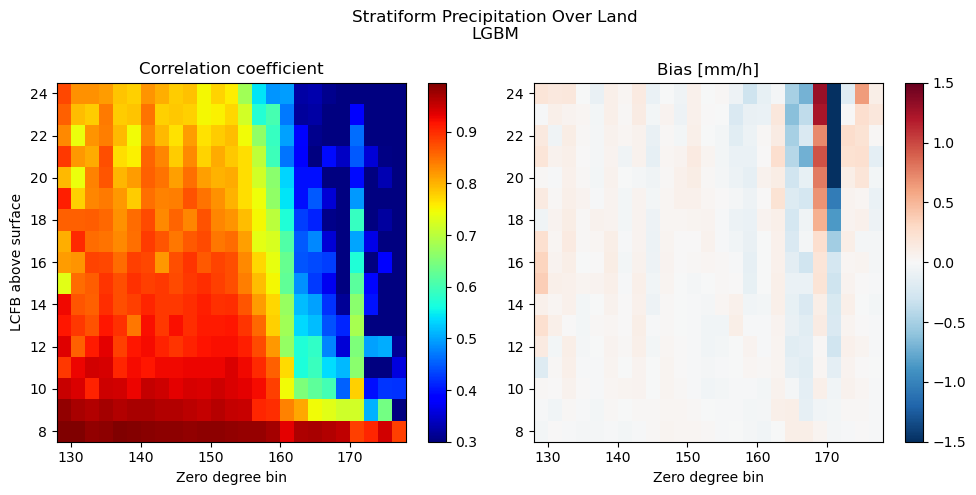

In [25]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.suptitle("Stratiform Precipitation Over Land\nLGBM")
plt.subplot(121)
plt.pcolormesh(np.arange(0,25)*2+129,np.arange(0,17)+8,(corr_map).T,cmap='jet',vmin=0.3)
plt.xlabel("Zero degree bin")
plt.ylabel("LCFB above surface")
plt.title("Correlation coefficient")
plt.colorbar()
plt.subplot(122)
xmap=129+2*np.arange(25)
ymap=np.arange(17)
plt.pcolormesh(xmap,ymap+8,bias_map.T,cmap='RdBu_r',vmin=-1.5,vmax=1.5)
plt.xlabel("Zero degree bin")
plt.title("Bias [mm/h]")
plt.colorbar()
plt.tight_layout()
plt.savefig("fig07_2_rev.png")

In [26]:
import matplotlib.pyplot as plt
y_pred_gb_opt=precip_lcfb_test
bias_map_p=np.zeros((25,17),float)
count_map_p=np.zeros((25,17),int)
y1_test_p=[[[] for j in range(17)] for i in range(25)]
y2_test_p=[[[] for j in range(17)] for i in range(25)]
for i,y_val in enumerate(y_pred_gb):
    ibz=int((bzd_test[i]-129)/2)
    if ibz<0: ibz=0
    if ibz>24: ibz=24
    bias_map_p[ibz,xrange_test[i]]+=y_pred_gb_opt[i]-y_test[i]
    y1_test_p[ibz][xrange_test[i]].append(y_pred_gb_opt[i])
    y2_test_p[ibz][xrange_test[i]].append(y_test[i])
    count_map_p[ibz,xrange_test[i]]+=1

a=np.nonzero(count_map_p>0)
bias_map_p[a]=bias_map_p[a]/count_map_p[a]
corr_map_p=np.zeros((25,17),float)
for i in range(25):
    for j in range(17):
        if count_map_p[i,j]>1:
            corr_map_p[i,j]=np.corrcoef(y1_test_p[i][j],y2_test_p[i][j])[0,1]
        else:
            corr_map_p[i,j]=np.nan

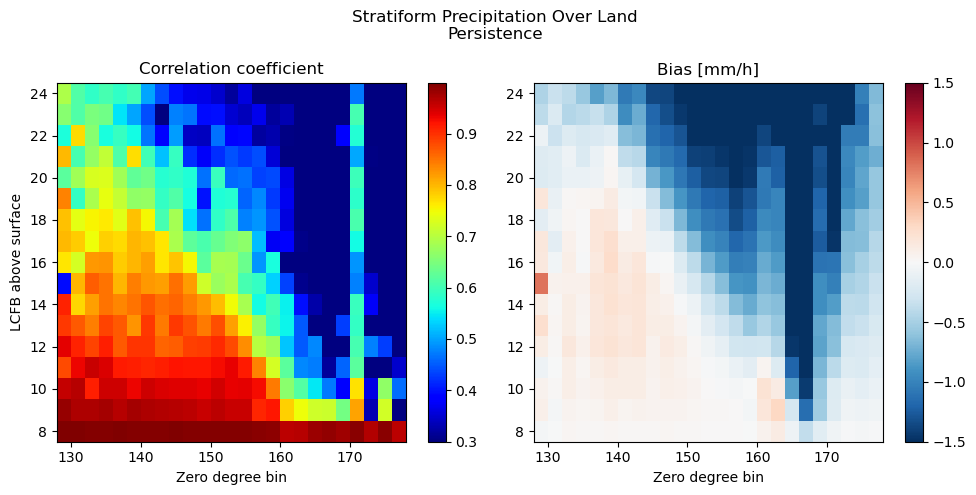

In [27]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.suptitle("Stratiform Precipitation Over Land\nPersistence")
plt.subplot(121)
plt.pcolormesh(np.arange(0,25)*2+129,np.arange(0,17)+8,(corr_map_p).T,cmap='jet',vmin=0.3)
plt.xlabel("Zero degree bin")
plt.ylabel("LCFB above surface")
plt.title("Correlation coefficient")
plt.colorbar()
plt.subplot(122)
xmap=129+2*np.arange(25)
ymap=np.arange(17)
plt.pcolormesh(xmap,ymap+8,bias_map_p.T,cmap='RdBu_r',vmin=-1.5,vmax=1.5)
plt.xlabel("Zero degree bin")
plt.title("Bias [mm/h]")
plt.colorbar()
plt.tight_layout()
plt.savefig("fig08_rev.png")

In [61]:
print(bzd_test.min(), bzd_test.max())
bias_map_train=np.zeros((25,17),float)
count_map_train=np.zeros((25,17),int)
y1=[[[] for j in range(17)] for i in range(25)]
y2=[[[] for j in range(17)] for i in range(25)]
for i,y_val in enumerate(precip_lcfb):
    ibz=int((bzd[i]-129)/2)
    if ibz<0: ibz=0
    if ibz>24: ibz=24
    bias_map_train[ibz,xrange[i]]+=precip_lcfb[i]-precip[i]
    y1[ibz][xrange[i]].append(precip_lcfb[i])
    y2[ibz][xrange[i]].append(precip[i])
    count_map_train[ibz,xrange[i]]+=1

129 177


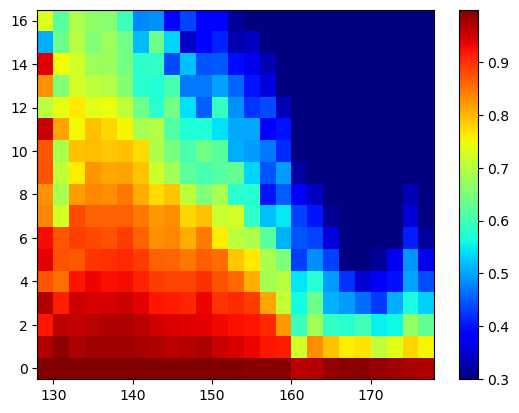

In [63]:
corr_map_train=np.zeros((25,17),float)
for i in range(25):
    for j in range(17):
        if count_map_train[i,j]>1:
            corr_map_train[i,j]=np.corrcoef(y1[i][j],y2[i][j])[0,1]
        else:
            corr_map_train[i,j]=np.nan
plt.pcolormesh(np.arange(0,25)*2+129,np.arange(0,17),(corr_map_train.T),cmap='jet',vmin=0.3)
plt.colorbar()

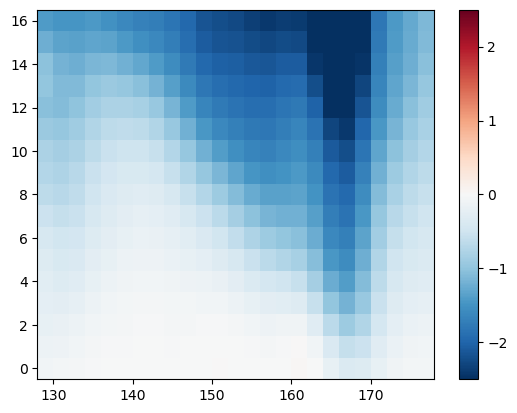

In [65]:
a=np.nonzero(count_map_train>0)
#bias_map_train[a]=bias_map_train[a]/count_map_train[a]
xmap=129+2*np.arange(25)
ymap=np.arange(17)
from scipy.ndimage import gaussian_filter
bias_map_train2=gaussian_filter(bias_map_train,1)
plt.pcolormesh(xmap,ymap,bias_map_train2.T,cmap='RdBu_r',vmin=-2.5,vmax=2.5)
plt.colorbar()

In [6]:
# import PCA
nt=X_flattend_scaled.shape[0]
n1=(3*nt)//4
from sklearn.decomposition import PCA
pca = PCA(n_components=.95)
pca.fit(X_flattend_scaled[:,:-2])

PCA(n_components=0.95)

In [ ]:
#import RandomizedSearchCV

#lgbm=lgb.LGBMRegressor(n_estimators=1000)
#gbreg=lgbm


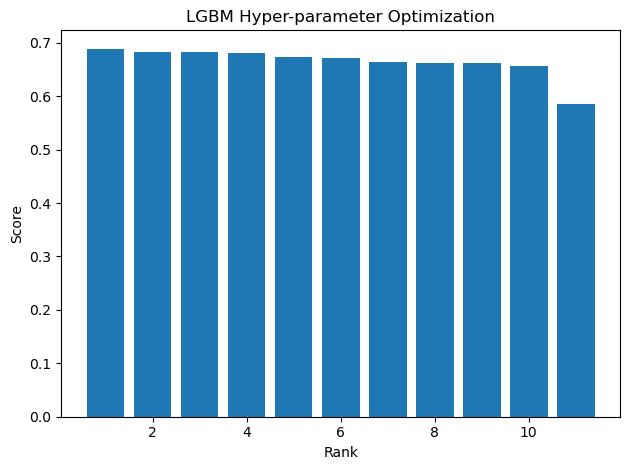

In [17]:
import matplotlib.pyplot as plt
plt.bar(random_search.cv_results_['rank_test_score'],random_search.cv_results_['mean_test_score']**0.5)
plt.xlabel("Rank")
plt.ylabel("Score")
plt.title("LGBM Hyper-parameter Optimization")
plt.tight_layout()
plt.savefig("fig_Randomized_Search_Land.png")

In [52]:
print(lgb_random_search.estimator.get_params())

{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 100, 'n_jobs': None, 'num_leaves': 31, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0}


In [7]:
print(pca.explained_variance_ratio_)
x_pca=pca.transform(X_flattend_scaled[:,:-2])


[0.67499688 0.13370809 0.0626729  0.02202891 0.01170876 0.00789497
 0.00572997 0.00494692 0.0045967  0.00429712 0.0040568  0.00384412
 0.00366262 0.0034974  0.00334465]


In [9]:
#X_train=X_flattend_scaled[:n1]
y_train=y_flattened[:n1]
#X_test=X_flattend_scaled[n1:]
y_test=y_flattened[n1:]
x_pca_scaled=(x_pca-x_pca.mean(axis=0))/x_pca.std(axis=0)
print(x_pca.mean(axis=0))
print(x_pca.std(axis=0))
X_knn=np.concatenate([x_pca_scaled, X_flattend_scaled[:,-2:]], axis=1)
print(X_knn.shape)

from sklearn.neighbors import KNeighborsRegressor
knn_reg=KNeighborsRegressor(n_neighbors=10, weights='distance')
knn_reg.fit(X_knn[:n1], y_train)
y_pred_knn=knn_reg.predict(X_knn[n1:])
print(np.corrcoef(y_test[:], y_pred_knn))

[ 1.94168229e-12 -7.10737165e-12  2.67915071e-12  1.90023775e-13
 -5.07016007e-12 -2.63118330e-12  4.21661763e-12  1.20357645e-12
  1.06877676e-12 -2.05193557e-12 -3.42841830e-12  1.46142641e-12
 -1.68586345e-12  1.60626622e-13  1.51991553e-12]
[8.21581934 3.65661174 2.50345564 1.48421398 1.08207036 0.88853662
 0.75696595 0.7033438  0.67798981 0.65552417 0.63693009 0.62000967
 0.60519551 0.59138804 0.57832913]
(3462343, 17)
[[1.        0.8090241]
 [0.8090241 1.       ]]


In [23]:
print(y_test.std(),y_test.mean())

4.233183222427275 3.165470994957094


In [40]:
# define a simple neural network with one hidden layer with 64 neurons
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
class Net(nn.Module):
    def __init__(self, n_features,n_hidden=64):
        super(Net, self).__init__()
        self.n_features = n_features   
        self.n_hidden = n_hidden
        self.fc1 = nn.Linear(n_features, n_hidden)
        self.fc2 = nn.Linear(n_hidden, n_hidden)
        self.fc3 = nn.Linear(n_hidden, 1)
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [45]:
# define training and testing datasets
print(X_knn)
X_nn_train = torch.tensor(X_knn[:n1], dtype=torch.float32)
y_nn_train = torch.tensor((y_train[:,np.newaxis]-3)/4.0, dtype=torch.float32)
X_nn_test = torch.tensor(X_knn[n1:], dtype=torch.float32)
y_nn_test = torch.tensor((y_test[:,np.newaxis].data-3)/4.0, dtype=torch.float32)

# import dataloader
class MyDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    
train_dataset = MyDataset(X_nn_train, y_nn_train)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

[[-1.85160608 -1.34724336  1.61138363  0.36356213 -0.66384043 -1.2741687 ]
 [-1.57666179 -0.39280618  1.47379886  0.04542243 -0.4540237  -1.11681955]
 [-1.75833477 -0.78160652  1.08785662  1.0380311  -0.54201802 -1.11681955]
 ...
 [ 0.94643841 -1.26270683 -2.53108016 -0.21397245 -0.2066042   0.4566719 ]
 [ 1.5400327  -2.59443554  0.2065447   0.46037048 -0.35468349 -1.2741687 ]
 [ 2.35497337  0.19227237  0.2849286   1.16733794  1.85725758 -0.80212126]]


In [46]:
#train the neural network
net = Net(X_knn.shape[1])
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)
loss_avg_L=[]
for epoch in range(100):
    loss_avg=0
    for i, data in enumerate(train_loader):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        loss_avg+=loss.item()
    if epoch % 2 == 0:
        print(epoch, loss_avg/len(train_loader))
    loss_avg_L.append(loss_avg/len(train_loader))

0 0.24978563432570203
2 0.23860970648731442
4 0.23642978995488942
6 0.23526034844758995
8 0.23424967657779278
10 0.2335557689477915
12 0.2333131281925768
14 0.23285375393533841
16 0.23257709907602916
18 0.23230078690106323
20 0.2319710006995033
22 0.23209615053398708
24 0.23147378724787537
26 0.2315796099108025
28 0.23148025424296273
30 0.23146315673237214
32 0.2314302018364826
34 0.23157245402580212


KeyboardInterrupt: 

In [44]:
print(outputs.shape)
print(labels.shape)

torch.Size([64, 1])
torch.Size([64])


In [35]:
print(np.corrcoef(X_knn[:n1,-2].data,y_train.data))
print(np.corrcoef(X_knn[n1:,-2],y_test))

[[1.         0.58515709]
 [0.58515709 1.        ]]
[[1.         0.69205464]
 [0.69205464 1.        ]]


0.829189004731287


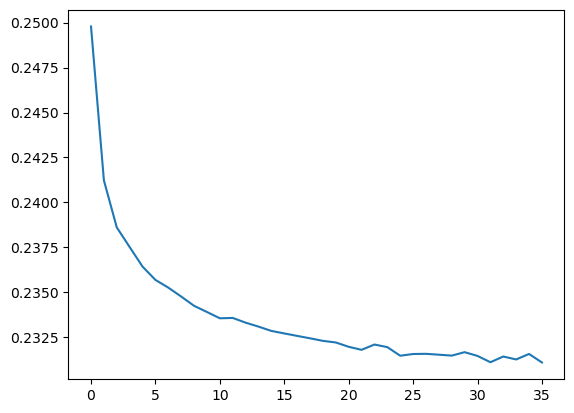

In [48]:
plt.plot(loss_avg_L)
y_nn_pred=net(X_nn_test)
print(np.corrcoef(y_nn_pred.detach().numpy().flatten(), y_nn_test.detach().numpy().flatten())[0,1])